In [1]:
library(Seurat)
library(Signac)
library(magrittr)
library(ggplot2)
library(BiocIO)
library(genomation)
library(Rsamtools)
library(parallel)
library(foreach)
library(SummarizedExperiment)
library(harmony)

Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built under R 4.3.2 but the current version is
4.3.3; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Loading required package: grid

Warning message:
“replacing previous import ‘Biostrings::pattern’ by ‘grid::pattern’ when loading ‘genomation’”
Loading required package: GenomeInfoDb

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    a

In [2]:
obj.seurat.qc.56 = readRDS("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/data/PBMC/1.prepare_data/1.seurat_pipeline.240620/obj.seurat.qc.56.rds")

Load annotated scRNA-seq dataseq, which is downloaded from https://github.com/GreenleafLab/MPAL-Single-Cell-2019?tab=readme-ov-file

In [3]:
obj.SummarizedExperiment.Hematopoiesis = readRDS("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/processed/PBMC_MPAL_Single_Cell_2019/scRNA-Healthy-Hematopoiesis-191120.rds")

filter intersected genes among datasets

In [4]:
gene.intersect = intersect(rownames(obj.SummarizedExperiment.Hematopoiesis@assays$data$counts),
                           rownames(obj.seurat.qc.56@assays$RNA$counts))
length(gene.intersect)

[1] 18980

Create a combinded seurat object

In [5]:
obj.seurat.merge =  CreateSeuratObject(
  counts = cbind(obj.SummarizedExperiment.Hematopoiesis@assays$data$counts[gene.intersect,],
                 obj.seurat.qc.56@assays$RNA$counts[gene.intersect,]),
  assay = "RNA"
)

In [6]:
obj.seurat.merge@meta.data$dataset = factor(c(as.character(obj.SummarizedExperiment.Hematopoiesis$Group),
                                              obj.seurat.qc.56$sample))

In [7]:
obj.seurat.merge$BioClassification = c(as.character(obj.SummarizedExperiment.Hematopoiesis$BioClassification),
                                       rep(NA,ncol(obj.seurat.qc.56)))

In [8]:
DefaultAssay(obj.seurat.merge) <- 'RNA'
obj.seurat.merge <- obj.seurat.merge %>%
  NormalizeData() %>%
  FindVariableFeatures() %>%
  ScaleData() %>%
  RunPCA()

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  EEF1B2, NPM1, HINT1, BTF3, PTMA, HNRNPA1, HMGN1, STMN1, YBX1, NUCB2 
	   PTPRCAP, UBB, HMGB1, PEBP1, RAN, GYPC, HSP90AB1, C1QBP, EBPL, DUT 
	   RANBP1, SNRPE, PRSS57, IMPDH2, IGLL1, UQCRH, TYMS, FABP5, TUBB, SPINK2 
Negative:  FCN1, NAMPT, VCAN, PLXDC2, PSAP, CLEC7A, SLC8A1, S100A9, TNFAIP2, GAB2 
	   DPYD, SERPINA1, DMXL2, ARHGAP26, TYMP, RBM47, MNDA, PLAUR, AOAH, LYZ 
	   SLC11A1, S100A8, TBXAS1, CTSS, CD14, MPEG1, MCTP1, HCK, CD83, RAB31 
PC_ 2 
Positive:  BCL11B, SKAP1, KLF12, ARHGAP15, PRKCH, CD247, IL32, CD69, CAMK4, RORA 
	   INPP4B, IL7R, TC2N, MAML2, DOCK10, PDE3B, SYNE2, CD96, ZBTB20, LTB 
	   BACH2, CDC14A, TNIK, THEMIS, AKT3, PITPNC1, TNRC6C, PRKCA, BCL2, ITK 
Negative:  FTL, AIF1, GSTP1, GAPDH, FTH1, HLA-DRA, CST3, TKT, YBX1, TXN 
	   TNFSF13B, MGST1, NPC2, RAB32, GLUL, GRN, LST1, UQCRH, SERPINB1, LMO2 
	   SPI1, YBX3, SLC25A5, AP1S2, HMGB2, CD74, CST

In [9]:
obj.seurat.merge <- RunHarmony(obj.seurat.merge, 
                               group.by.vars = "dataset",
                               dims.use	= 1:30)

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony converged after 6 iterations



In [10]:
obj.seurat.merge <- RunUMAP(obj.seurat.merge, 
                            reduction = "harmony", 
                            dims = 1:30)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
15:50:14 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

15:50:14 Read 53991 rows and found 30 numeric columns

15:50:14 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

15:50:14 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:50:19 Writing NN index file to 

In [22]:
obj.seurat.merge <- obj.seurat.merge %>%
  FindNeighbors(dims = 1:30,reduction = "harmony") %>%
  FindClusters(resolution = 3)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 53991
Number of edges: 1961993

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8361
Number of communities: 52
Elapsed time: 15 seconds


In [13]:
dir.create("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/output/PBMC/1.prepare_data/3.annotate_cell_type/",
           recursive = T)

Warning message in dir.create("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/output/PBMC/1.prepare_data/3.annotate_cell_type/", :
“'/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/output/PBMC/1.prepare_data/3.annotate_cell_type' already exists”


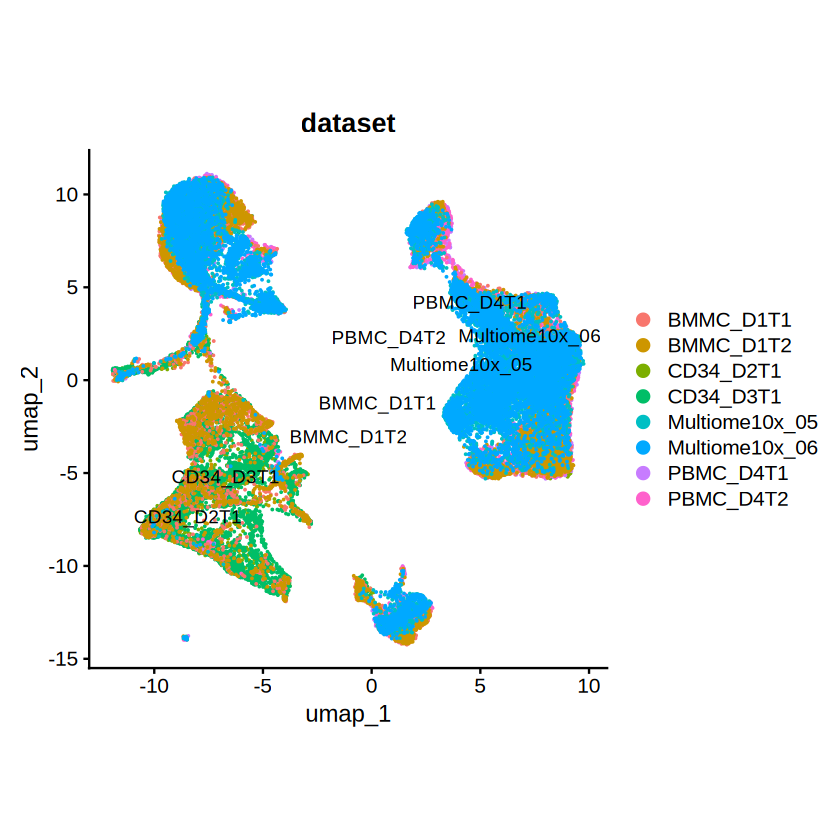

In [14]:
p = DimPlot(obj.seurat.merge,
            group.by = "dataset",
            label = TRUE,
            repel = TRUE,
            reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/output/PBMC/1.prepare_data/3.annotate_cell_type/UMAP.RNA.dataset.pdf", 
       plot = p, 
       width = 10, height = 8)

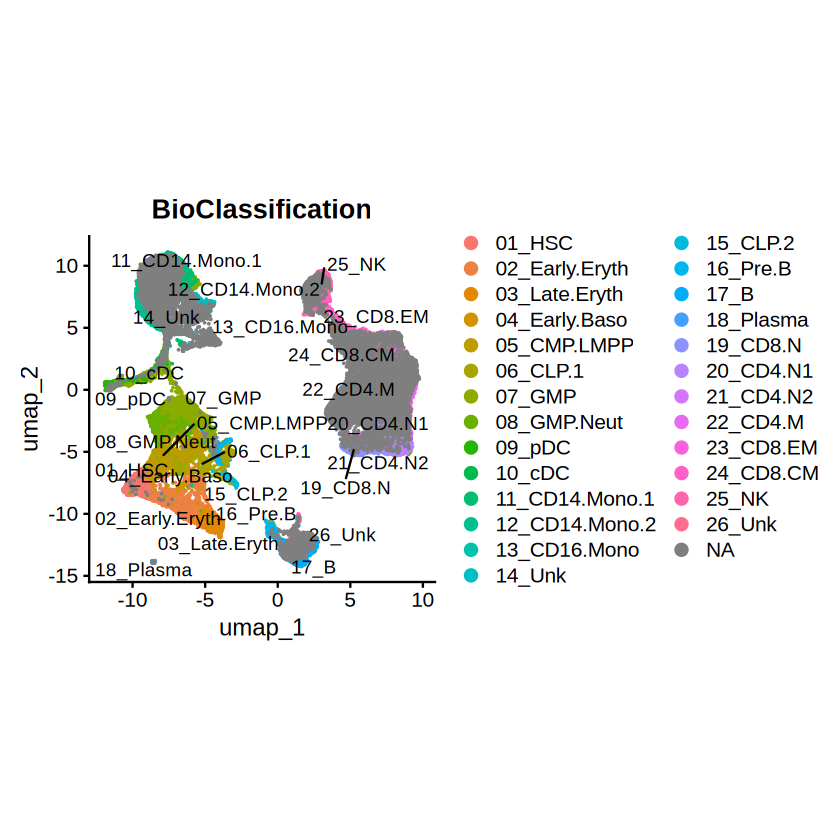

In [15]:
p = DimPlot(obj.seurat.merge,
            group.by = "BioClassification",
            label = TRUE,
            repel = TRUE,
            reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/output/PBMC/1.prepare_data/3.annotate_cell_type/UMAP.RNA.BioClassification.pdf", 
       plot = p, 
       width = 10, height = 8)

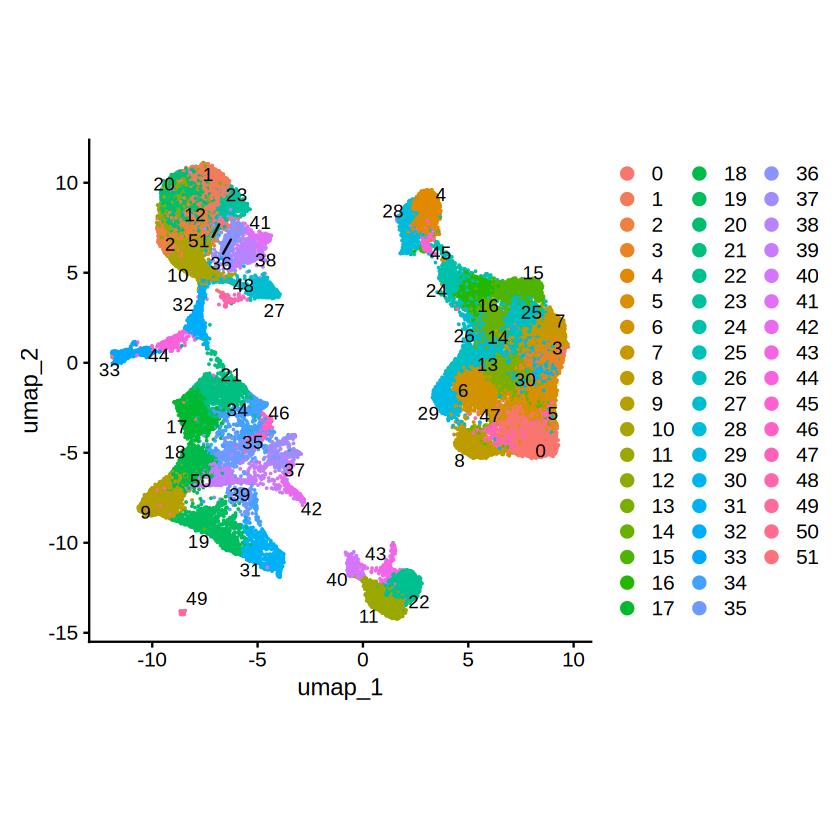

In [116]:
p = DimPlot(obj.seurat.merge,
            # group.by = "BioClassification",
            label = TRUE,
            repel = TRUE,
            reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/output/PBMC/1.prepare_data/3.annotate_cell_type/UMAP.RNA.pdf", 
       plot = p, 
       width = 10, height = 8)

In [23]:
obj.seurat.Hematopoiesis = subset(obj.seurat.merge,
                                  subset = dataset %in% c("BMMC_D1T1",
                                                          "BMMC_D1T2",
                                                          "CD34_D2T1",
                                                          "CD34_D31",
                                                          "PBMC_D41",
                                                          "PBMC_D472"))

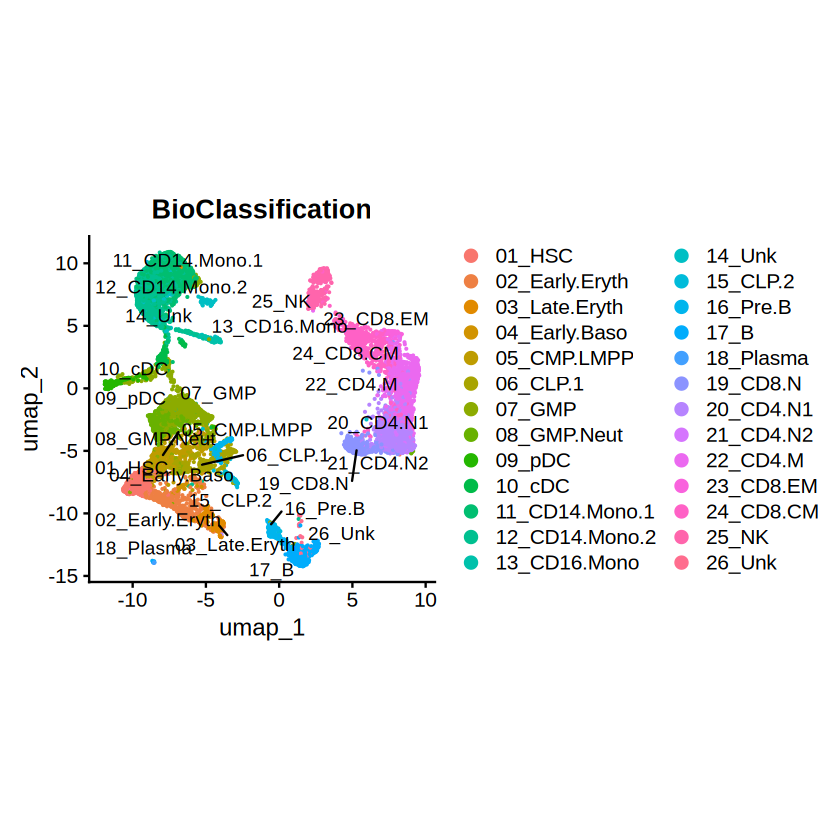

In [18]:
p = DimPlot(obj.seurat.Hematopoiesis,
            group.by = "BioClassification",
            label = TRUE,
            repel = TRUE,
            reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/output/PBMC/1.prepare_data/3.annotate_cell_type/UMAP.RNA.BioClassification.Hematopoiesis.pdf", 
       plot = p, 
       width = 10, height = 8)

In [24]:
table(obj.seurat.Hematopoiesis@meta.data[,c("BioClassification","seurat_clusters")])

                 seurat_clusters
BioClassification    0    1    2    3    4    5    6    7    8    9   10   11
   01_HSC            6    0    0    0    0    1    0    0    0  654    0    0
   02_Early.Eryth    3    0    0    0    0    0    0    0    0   17    0    0
   03_Late.Eryth     0    0    0    0    0    0    0    0    0    0    0    0
   04_Early.Baso     0    0    0    0    0    0    0    0    0    0    0    0
   05_CMP.LMPP       8    0    0    0    0    0    0    0    1   49    0    0
   06_CLP.1          2    0    0    0    0    0    0    0    0    4    0    5
   07_GMP            0    0    0    0    0    0    0    0    0    8    0    0
   08_GMP.Neut      10    0    0    0    0    0    0    0    0    0    0    0
   09_pDC            0    0    0    0    1    0    0    0    0    0    0    0
   10_cDC            0    1    0    0    0    0    0    0    0    0    5    0
   11_CD14.Mono.1    0  545  105    0    0    0    0    0    0    0    8    0
   12_CD14.Mono.2    0  203  50

In [30]:
table(obj.seurat.Hematopoiesis$BioClassification)


        01_HSC 02_Early.Eryth  03_Late.Eryth  04_Early.Baso    05_CMP.LMPP 
           818            541            156             43            750 
      06_CLP.1         07_GMP    08_GMP.Neut         09_pDC         10_cDC 
           418           1108            579            359            133 
11_CD14.Mono.1 12_CD14.Mono.2   13_CD16.Mono         14_Unk       15_CLP.2 
          1306           1264            114            184            291 
      16_Pre.B           17_B      18_Plasma       19_CD8.N      20_CD4.N1 
           699            658             12            733           2380 
     21_CD4.N2       22_CD4.M      23_CD8.EM      24_CD8.CM          25_NK 
            83           1218             49            744            350 
        26_Unk 
            36 

In [134]:
obj.seurat.merge$cell_type = as.character(obj.seurat.merge$seurat_clusters)
rev(sort(table(obj.seurat.Hematopoiesis@meta.data[obj.seurat.Hematopoiesis$seurat_clusters == 37,"BioClassification"])))


16_Pre.B 06_CLP.1    25_NK 15_CLP.2 
     247       87        4        3 

In [137]:
obj.seurat.merge@meta.data[obj.seurat.merge$cell_type %in% c(9,50),"cell_type"] = "01_HSC"
obj.seurat.merge@meta.data[obj.seurat.merge$cell_type %in% c(19),"cell_type"] = "02_Early.Eryth"
obj.seurat.merge@meta.data[obj.seurat.merge$cell_type %in% c(31),"cell_type"] = "03_Late.Eryth"
obj.seurat.merge@meta.data[obj.seurat.merge$cell_type %in% c(),"cell_type"] = "04_Early.Baso"
obj.seurat.merge@meta.data[obj.seurat.merge$cell_type %in% c(18,35),"cell_type"] = "05_CMP.LMPP"
obj.seurat.merge@meta.data[obj.seurat.merge$cell_type %in% c(39),"cell_type"] = "06_CLP.1"
obj.seurat.merge@meta.data[obj.seurat.merge$cell_type %in% c(34,44,46,21),"cell_type"] = "07_GMP"
obj.seurat.merge@meta.data[obj.seurat.merge$cell_type %in% c(17),"cell_type"] = "08_GMP.Neut"
obj.seurat.merge@meta.data[obj.seurat.merge$cell_type %in% c(33),"cell_type"] = "09_pDC"
obj.seurat.merge@meta.data[obj.seurat.merge$cell_type %in% c(32,48),"cell_type"] = "10_cDC"
obj.seurat.merge@meta.data[obj.seurat.merge$cell_type %in% c(1,23),"cell_type"] = "11_CD14.Mono.1"
obj.seurat.merge@meta.data[obj.seurat.merge$cell_type %in% c(2,10,12,20,51),"cell_type"] = "12_CD14.Mono.2"
obj.seurat.merge@meta.data[obj.seurat.merge$cell_type %in% c(27),"cell_type"] = "13_CD16.Mono"
obj.seurat.merge@meta.data[obj.seurat.merge$cell_type %in% c(41,36,38),"cell_type"] = "14_Unk"
obj.seurat.merge@meta.data[obj.seurat.merge$cell_type %in% c(42),"cell_type"] = "15_CLP.2"
obj.seurat.merge@meta.data[obj.seurat.merge$cell_type %in% c(37,40),"cell_type"] = "16_Pre.B"
obj.seurat.merge@meta.data[obj.seurat.merge$cell_type %in% c(11,22),"cell_type"] = "17_B"
obj.seurat.merge@meta.data[obj.seurat.merge$cell_type %in% c(49),"cell_type"] = "18_Plasma"
obj.seurat.merge@meta.data[obj.seurat.merge$cell_type %in% c(8),"cell_type"] = "19_CD8.N"
obj.seurat.merge@meta.data[obj.seurat.merge$cell_type %in% c(0,5,47),"cell_type"] = "20_CD4.N1"
obj.seurat.merge@meta.data[obj.seurat.merge$cell_type %in% c(),"cell_type"] = "21_CD4.N2"
obj.seurat.merge@meta.data[obj.seurat.merge$cell_type %in% c(3,7,13,25,30,26,29,6),"cell_type"] = "22_CD4.M"
obj.seurat.merge@meta.data[obj.seurat.merge$cell_type %in% c(),"cell_type"] = "23_CD8.EM"
obj.seurat.merge@meta.data[obj.seurat.merge$cell_type %in% c(14,15,16,24),"cell_type"] = "24_CD8.CM"
obj.seurat.merge@meta.data[obj.seurat.merge$cell_type %in% c(4,28,45),"cell_type"] = "25_NK"
obj.seurat.merge@meta.data[obj.seurat.merge$cell_type %in% c(43),"cell_type"] = "26_Unk"

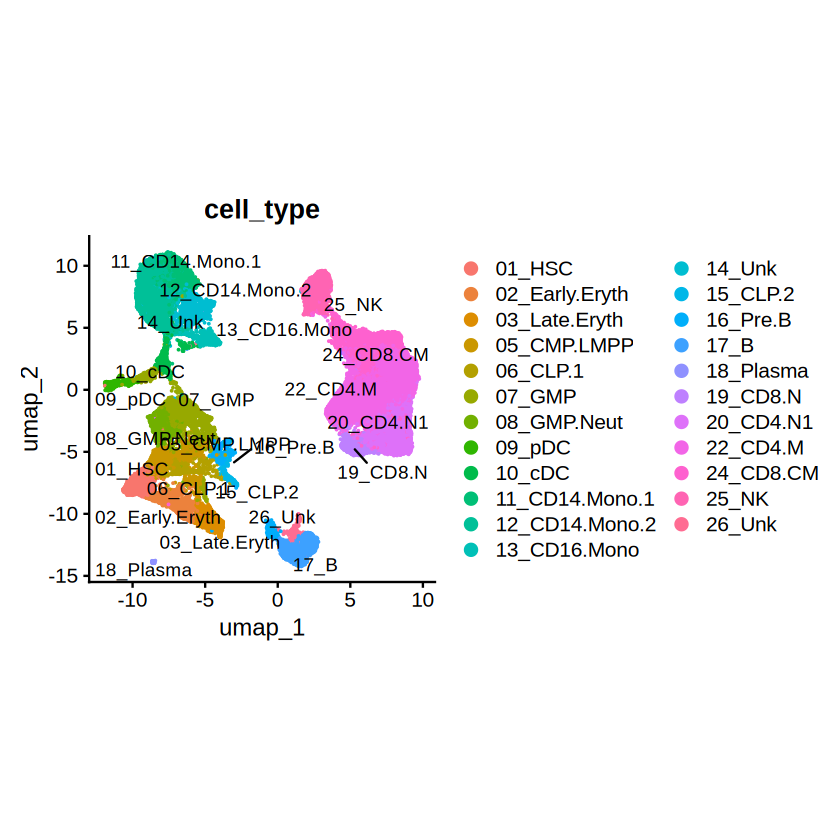

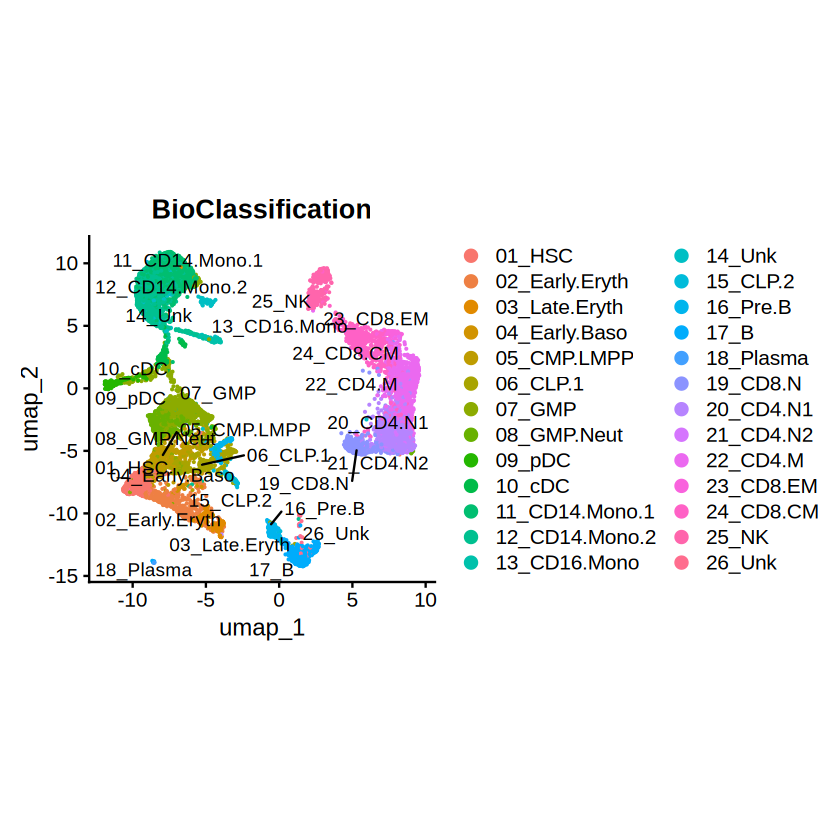

In [138]:
p = DimPlot(obj.seurat.merge,
            group.by = "cell_type",
            label = TRUE,
            repel = TRUE,
            reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/output/PBMC/1.prepare_data/3.annotate_cell_type/UMAP.RNA.cell_type.pdf", 
       plot = p, 
       width = 10, height = 8)
p = DimPlot(obj.seurat.Hematopoiesis,
            group.by = "BioClassification",
            label = TRUE,
            repel = TRUE,
            reduction = "umap")  +
  theme(aspect.ratio=1)
p

In [139]:
obj.seurat.PBMC = subset(obj.seurat.merge,
                         subset = dataset %in% c("Multiome10x_05",
                                                 "Multiome10x_06"))

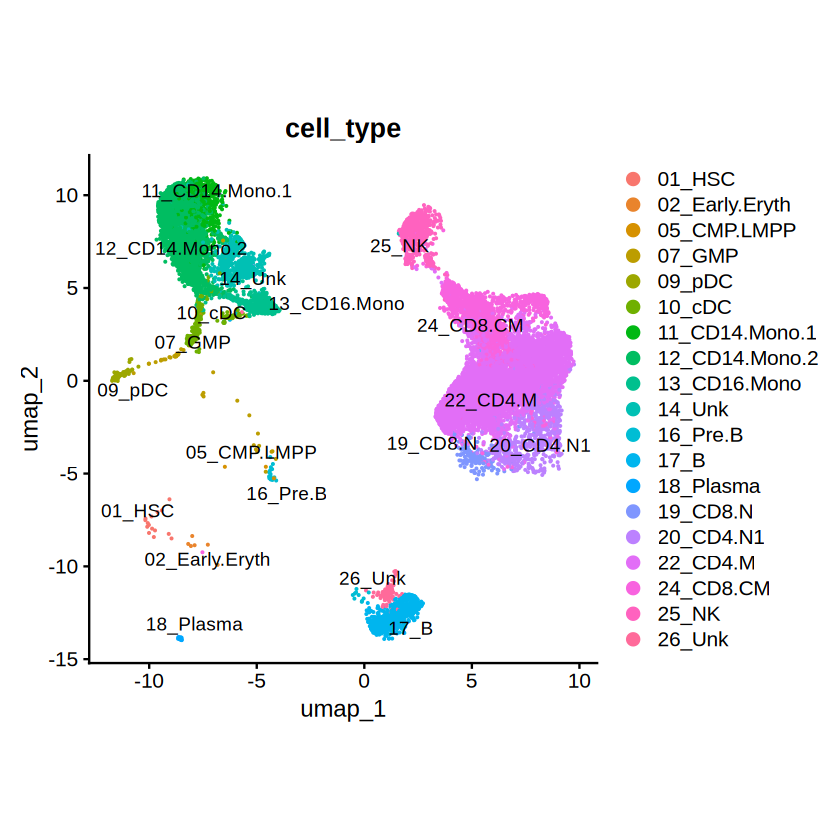

In [140]:
p = DimPlot(obj.seurat.PBMC,
            group.by = "cell_type",
            label = TRUE,
            repel = TRUE,
            reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/output/PBMC/1.prepare_data/3.annotate_cell_type/UMAP.RNA.cell_type.PBMC.pdf", 
       plot = p, 
       width = 10, height = 8)

In [144]:
df.cell_type = data.frame(cell_type = names(table(obj.seurat.PBMC$cell_type)),
                          cell_number = table(obj.seurat.PBMC$cell_type),
                          total_fragment_count = NA,
                          total_UMI_count = NA)
rownames(df.cell_type) = df.cell_type$cell_type
df.cell_type

,cell_type,cell_number.Var1,cell_number.Freq,total_fragment_count,total_UMI_count
,<chr>,<fct>,<int>,<lgl>,<lgl>
01_HSC,01_HSC,01_HSC,15,NA,NA
02_Early.Eryth,02_Early.Eryth,02_Early.Eryth,6,NA,NA
05_CMP.LMPP,05_CMP.LMPP,05_CMP.LMPP,3,NA,NA
07_GMP,07_GMP,07_GMP,51,NA,NA
09_pDC,09_pDC,09_pDC,93,NA,NA
10_cDC,10_cDC,10_cDC,333,NA,NA
11_CD14.Mono.1,11_CD14.Mono.1,11_CD14.Mono.1,461,NA,NA
12_CD14.Mono.2,12_CD14.Mono.2,12_CD14.Mono.2,2713,NA,NA
13_CD16.Mono,13_CD16.Mono,13_CD16.Mono,593,NA,NA


In [148]:
for(cell_type.tmp in df.cell_type$cell_type){
    cell_names.tmp = colnames(obj.seurat.PBMC)[obj.seurat.PBMC@meta.data$cell_type == cell_type.tmp]
    df.cell_type[cell_type.tmp,"total_fragment_count"] = sum(obj.seurat.qc.56@meta.data[cell_names.tmp,"atac_fragments"])
    df.cell_type[cell_type.tmp,"total_UMI_count"] = sum(obj.seurat.qc.56@meta.data[cell_names.tmp,"gex_umis_count"])
}

In [150]:
df.cell_type$mean_fragment_count = round(df.cell_type$total_fragment_count / df.cell_type$cell_number.Freq,0)
df.cell_type$mean_UMI_count = round(df.cell_type$total_UMI_count / df.cell_type$cell_number.Freq,0)

In [151]:
df.cell_type

,cell_type,cell_number.Var1,cell_number.Freq,total_fragment_count,total_UMI_count,mean_fragment_count,mean_UMI_count
,<chr>,<fct>,<int>,<int>,<int>,<dbl>,<dbl>
01_HSC,01_HSC,01_HSC,15,464305,88217,30954,5881
02_Early.Eryth,02_Early.Eryth,02_Early.Eryth,6,238058,42317,39676,7053
05_CMP.LMPP,05_CMP.LMPP,05_CMP.LMPP,3,106860,30292,35620,10097
07_GMP,07_GMP,07_GMP,51,1262139,362047,24748,7099
09_pDC,09_pDC,09_pDC,93,2750429,439958,29575,4731
10_cDC,10_cDC,10_cDC,333,12474026,2531697,37460,7603
11_CD14.Mono.1,11_CD14.Mono.1,11_CD14.Mono.1,461,11974791,1724735,25976,3741
12_CD14.Mono.2,12_CD14.Mono.2,12_CD14.Mono.2,2713,67443588,10893163,24859,4015
13_CD16.Mono,13_CD16.Mono,13_CD16.Mono,593,13978891,3355850,23573,5659


In [152]:
dir.create("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/data/PBMC/1.prepare_data/3.annotate_cell_type/",
           recursive = T)

In [153]:
write.csv(df.cell_type,
          "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/data/PBMC/1.prepare_data/3.annotate_cell_type/df.cell_type.csv")

In [154]:
saveRDS(obj.seurat.merge,
        "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/data/PBMC/1.prepare_data/3.annotate_cell_type/obj.seurat.merge.rds")

In [160]:
obj.seurat.qc.56@meta.data[rownames(obj.seurat.PBMC@meta.data),"cell_type3"] = obj.seurat.PBMC@meta.data$cell_type
table(obj.seurat.qc.56$cell_type3)


        01_HSC 02_Early.Eryth    05_CMP.LMPP         07_GMP         09_pDC 
            15              6              3             51             93 
        10_cDC 11_CD14.Mono.1 12_CD14.Mono.2   13_CD16.Mono         14_Unk 
           333            461           2713            593           1224 
      16_Pre.B           17_B      18_Plasma       19_CD8.N      20_CD4.N1 
            27            882             48            146            773 
      22_CD4.M      24_CD8.CM          25_NK         26_Unk 
          8006           2129            757            149 

In [161]:
saveRDS(obj.seurat.qc.56,
        "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/data/PBMC/1.prepare_data/3.annotate_cell_type/obj.seurat.qc.56.rds")

Generate fragment files for each cell type

In [162]:
dir_path.frag_split = "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/data/PBMC/1.prepare_data/3.annotate_cell_type/fragments_split/"
dir.create(dir_path.frag_split,recursive = T)

In [163]:
Signac::SplitFragments(obj.seurat.qc.56,
                      assay = "ATAC_empty",
                      group.by = "cell_type3",
                      append = F,
                      outdir = dir_path.frag_split)

Processing file /maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/processed/10x_multiome_230720/10x/cellranger_res/Multiome10x_03/outs/atac_fragments.tsv.gz




Processing file /maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/processed/10x_multiome_230720/10x/cellranger_res/Multiome10x_04/outs/atac_fragments.tsv.gz




Processing file /maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/processed/10x_multiome_230720/10x/cellranger_res/Multiome10x_05/outs/atac_fragments.tsv.gz




Processing file /maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/processed/10x_multiome_230720/10x/cellranger_res/Multiome10x_06/outs/atac_fragments.tsv.gz






In [164]:
cell_types = unique(obj.seurat.qc.56$cell_type3)
names.sample = c("Multiome10x_03",
                 "Multiome10x_04",
                 "Multiome10x_05",
                 "Multiome10x_06")
my.cluster <- parallel::makeCluster(
  5,
  type = "PSOCK"
)
doParallel::registerDoParallel(cl = my.cluster)
foreach (n.tmp = 1:length(names.sample)) %dopar% {
  for(name.cell_type in cell_types) {
    cat(name.cell_type,n.tmp,"\n")
    
    path.frag.input = paste(dir_path.frag_split,
                          "/",
                          name.cell_type,
                          ".",
                          n.tmp,
                          ".bed",
                          sep = "")
    path.frag.output = paste(dir_path.frag_split,
                          "/",
                          name.cell_type,
                          ".",
                          n.tmp,
                          ".bed.gz",
                          sep = "")
    if (file.info(path.frag.input)$size > 0) {
      df.frag = 
        read.delim(path.frag.input,
                   header = F)
      df.frag[,4] = paste(names.sample[n.tmp],
                          df.frag[,4],
                          sep = "_")
      write.table(df.frag,
              gzfile(path.frag.output),
              col.names = F,
              row.names = F,
              quote = F,
              sep = "\t")

    }
  }
}
parallel::stopCluster(cl = my.cluster)

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

Generate RNA count matrix for each cell type

In [165]:
dir_path.rna_matrix = "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/data/PBMC/1.prepare_data/3.annotate_cell_type/RNA_count_matrix/"
dir.create(dir_path.rna_matrix,recursive = T)

In [166]:
for(name.cell_type in unique(obj.seurat.qc.56$cell_type3)){
  matrix.tmp = 
    obj.seurat.qc.56@assays$RNA$count[,obj.seurat.qc.56$cell_type3 == name.cell_type]
  write.csv(as.data.frame(matrix.tmp),
            gzfile(paste(dir_path.rna_matrix,
                         "/",
                         name.cell_type,
                         ".rna_count_matrix.csv.gz",
                        sep = "")),
            quote = F)
}

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.7 GiB”


In [167]:
write.csv(t(as.data.frame(obj.seurat.qc.56@assays$RNA$count)),
          gzfile("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/data/PBMC/1.prepare_data/3.annotate_cell_type/rna_count_matrix.t.csv.gz"),
          quote = F)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 8.6 GiB”


In [168]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux 8.10 (Ootpa)

Matrix products: default
BLAS/LAPACK: /maps/projects/ralab/people/lpm537/software/anaconda3/envs/Notebook_E2G_240505/lib/libopenblasp-r0.3.27.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Copenhagen
tzcode source: system (glibc)

attached base packages:
 [1] parallel  stats4    grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] harmony_1.2.0               Rcpp_1.0.12                
 [3] SummarizedExperiment_1.30.2 Biobase_2.60.0             
